# Análisis de N-gramas

En este notebook exploraremos el texto de los tweets descompuesto en n-gramas.

Las motivaciones para este análisis son:

* Analizar si existe alguna relación entre la presencia de ciertos n-gramas y el target de los tweets.

* Obtener una posible representación más adecuada para los modelos que se entrenarán más adelante en la materia para poder predecir si un tweet es sobre un desastre o no.

In [1]:
import pandas as pd
pd.set_option('max_colwidth', -1)
import string
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
sns.set()

[nltk_data] Downloading package stopwords to /home/ndv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../dataset/train.csv', usecols=['text', 'target'], encoding='utf-8-sig')
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [3]:
# Quitamos las urls
df['text'] = df['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)

# Quitamos user mentions, signos de puntuación, hashtags y stopwords.
def clean_text(text):
    words = text.lower().split(' ')
    text = ' '.join([word for word in words if not word.startswith('@') and word not in stopwords.words('english')])
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['text'] = df['text'].apply(clean_text)

In [4]:
df.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,13000 people receive wildfires evacuation orders california,1
4,got sent photo ruby alaska smoke wildfires pours school,1


In [5]:
def extract_ngrams(text, n):
    tokens = word_tokenize(text)
    return list(nltk.ngrams(tokens, n))

## Unigramas

Ya contamos con un análisis hecho por palabra (unigrama).

## Bigramas

Extraeremos los bigramas de cada tweet y luego veremos el top 10 de bigramas tanto para tweets reales como para no reales.

In [6]:
df_bi = df.copy()
df_bi['bigrams'] = df_bi['text'].apply(lambda x: extract_ngrams(x, 2))

In [7]:
df_bi.head()

,text,target,bigrams
0,deeds reason earthquake may allah forgive us,1,"[(deeds, reason), (reason, earthquake), (earthquake, may), (may, allah), (allah, forgive), (forgive, us)]"
1,forest fire near la ronge sask canada,1,"[(forest, fire), (fire, near), (near, la), (la, ronge), (ronge, sask), (sask, canada)]"
2,residents asked shelter place notified officers evacuation shelter place orders expected,1,"[(residents, asked), (asked, shelter), (shelter, place), (place, notified), (notified, officers), (officers, evacuation), (evacuation, shelter), (shelter, place), (place, orders), (orders, expected)]"
3,13000 people receive wildfires evacuation orders california,1,"[(13000, people), (people, receive), (receive, wildfires), (wildfires, evacuation), (evacuation, orders), (orders, california)]"
4,got sent photo ruby alaska smoke wildfires pours school,1,"[(got, sent), (sent, photo), (photo, ruby), (ruby, alaska), (alaska, smoke), (smoke, wildfires), (wildfires, pours), (pours, school)]"


In [8]:
df_bi_real = df_bi[df_bi['target'] == 1][['bigrams', 'target']]
df_bi_fake = df_bi[df_bi['target'] == 0][['bigrams', 'target']]

In [9]:
real_bigrams_vc = df_bi_real['bigrams'].explode().value_counts().head(10)
fake_bigrams_vc = df_bi_fake['bigrams'].explode().value_counts().head(10)

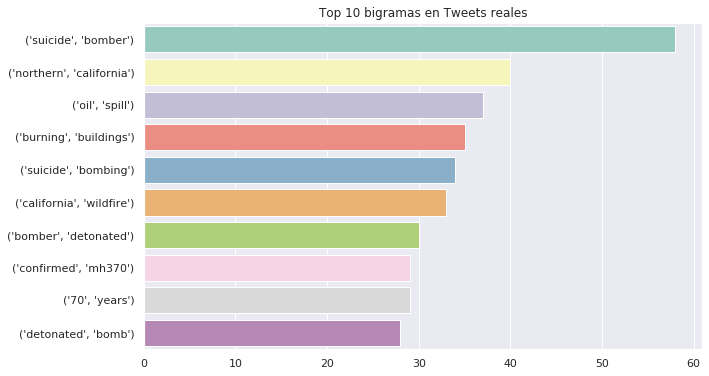

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(y=real_bigrams_vc.index, x=real_bigrams_vc.values, palette='Set3')
plt.title("Top 10 bigramas en Tweets reales")
plt.show()

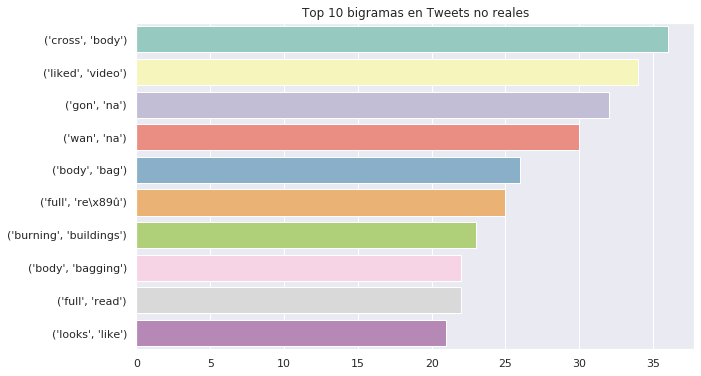

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(y=fake_bigrams_vc.index, x=fake_bigrams_vc.values, palette='Set3')
plt.title("Top 10 bigramas en Tweets no reales")
plt.show()

Dato de color: notar que el bigrama `('burning', 'buildings')` se encuentra presente en ambas clases.

## Trigramas

Finalmente haremos lo mismo para los trigramas, extraerlos y luego armar un top 10 para cada clase.

In [12]:
df_tri = df.copy()
df_tri['trigrams'] = df_tri['text'].apply(lambda x: extract_ngrams(x, 3))

In [13]:
df_tri.head()

,text,target,trigrams
0,deeds reason earthquake may allah forgive us,1,"[(deeds, reason, earthquake), (reason, earthquake, may), (earthquake, may, allah), (may, allah, forgive), (allah, forgive, us)]"
1,forest fire near la ronge sask canada,1,"[(forest, fire, near), (fire, near, la), (near, la, ronge), (la, ronge, sask), (ronge, sask, canada)]"
2,residents asked shelter place notified officers evacuation shelter place orders expected,1,"[(residents, asked, shelter), (asked, shelter, place), (shelter, place, notified), (place, notified, officers), (notified, officers, evacuation), (officers, evacuation, shelter), (evacuation, shelter, place), (shelter, place, orders), (place, orders, expected)]"
3,13000 people receive wildfires evacuation orders california,1,"[(13000, people, receive), (people, receive, wildfires), (receive, wildfires, evacuation), (wildfires, evacuation, orders), (evacuation, orders, california)]"
4,got sent photo ruby alaska smoke wildfires pours school,1,"[(got, sent, photo), (sent, photo, ruby), (photo, ruby, alaska), (ruby, alaska, smoke), (alaska, smoke, wildfires), (smoke, wildfires, pours), (wildfires, pours, school)]"


In [14]:
df_tri_real = df_tri[df_tri['target'] == 1][['trigrams', 'target']]
df_tri_fake = df_tri[df_tri['target'] == 0][['trigrams', 'target']]

In [15]:
real_trigrams_vc = df_tri_real['trigrams'].explode().value_counts().head(10)
fake_trigrams_vc = df_tri_fake['trigrams'].explode().value_counts().head(10)

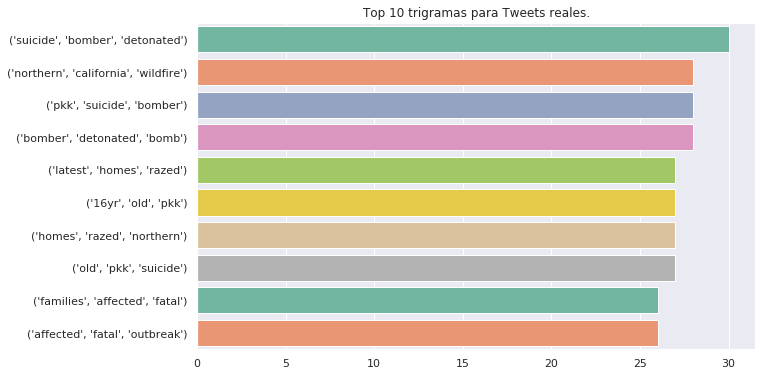

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(x=real_trigrams_vc.values, y=real_trigrams_vc.index, palette='Set2')
plt.title('Top 10 trigramas para Tweets reales.')
plt.show()

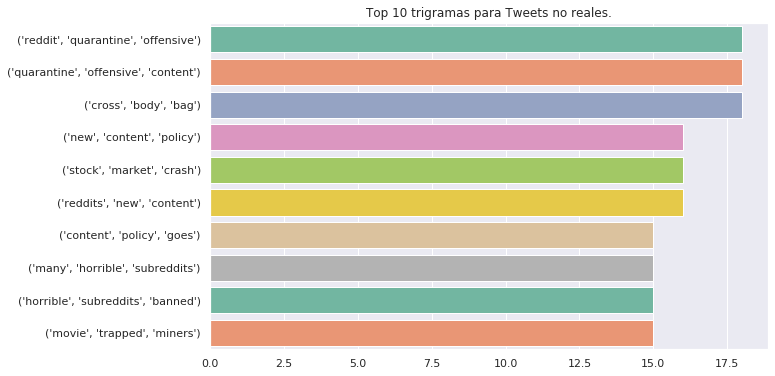

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(x=fake_trigrams_vc.values, y=fake_trigrams_vc.index, palette='Set2')
plt.title('Top 10 trigramas para Tweets no reales.')
plt.show()

Se puede observar que los trigramas de mayor frecuencia de los Tweets reales brindan suficiente contexto como para entender que representan un accidente/desastre, al menos al ojo humano.

En el caso de los Tweets falsos, no se puede hacer la misma observación. Parecieran estar relacionados a redes sociales o bien sitios de compras.

Tanto en el caso de los bigramas como en los trigramas, notamos que hay información muy importante en los mismos ya que nos proveen información contextual sobre Tweet.

A continuación intentaremos transformar el texto de los Tweets a una representación vectorial, utilizando distintos enfoques, y realizar una visualización en cada caso para explorar si se observa algo de interés en relación a las clases. 

# Bag of Words + SVD

En primer instancia utilizaremos Bag of Words pero agrupando por unigramas, bigramas y trigramas.

Utilizaremos SVD para reducir dimensiones ya que estaremos trabajando con matrices dispersas.

~ Explicar Bag of Words aquí ~ 

In [18]:
df_bi['bigrams'].explode().describe()

count     59768            
unique    45323            
top       (suicide, bomber)
freq      58               
Name: bigrams, dtype: object

In [19]:
df_tri['trigrams'].explode().describe()

count     52297                       
unique    42850                       
top       (suicide, bomber, detonated)
freq      30                          
Name: trigrams, dtype: object

## Unigramas

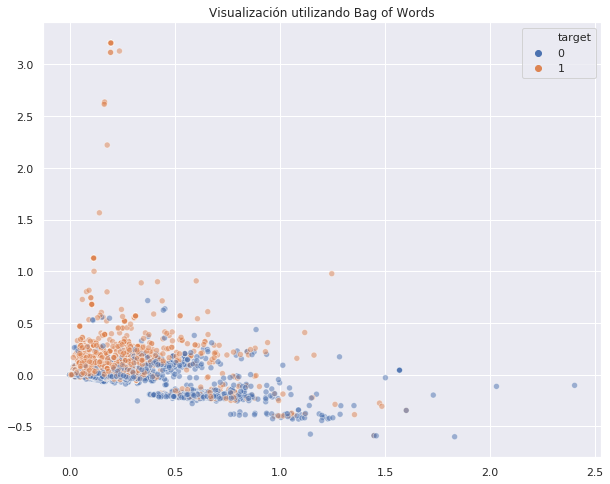

In [20]:
unigram_cv = CountVectorizer()
unigrams = unigram_cv.fit_transform(df['text'])

svd = TruncatedSVD()
reduced_unigrams = svd.fit_transform(unigrams)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=reduced_unigrams[:,0], y=reduced_unigrams[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando Bag of Words")
plt.show()

## Bigramas

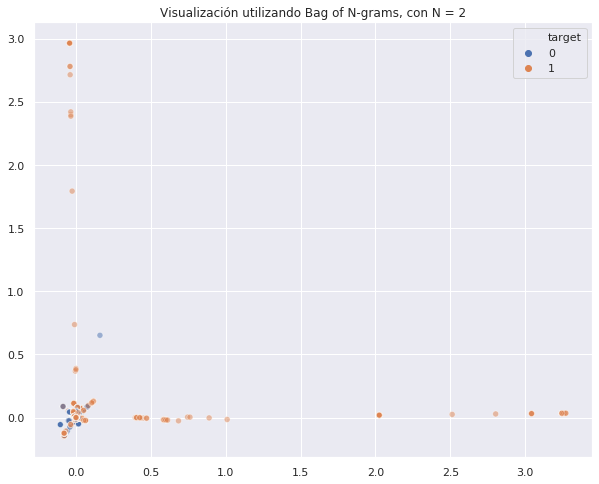

In [21]:
bigram_cv = CountVectorizer(ngram_range=(2,2))
bigrams = bigram_cv.fit_transform(df['text'])

svd = TruncatedSVD()
reduced_bigrams = svd.fit_transform(bigrams)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=reduced_bigrams[:,0], y=reduced_bigrams[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando Bag of N-grams, con N = 2")
plt.show()

## Trigramas

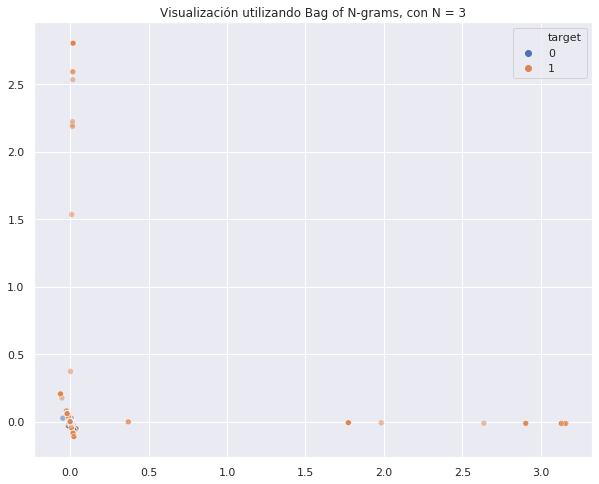

In [22]:
trigram_cv = CountVectorizer(ngram_range=(3,3))
trigrams = trigram_cv.fit_transform(df['text'])

svd = TruncatedSVD()
reduced_trigrams = svd.fit_transform(trigrams)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=reduced_trigrams[:,0], y=reduced_trigrams[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando Bag of N-grams, con N = 3")
plt.show()

# TF-IDF

~ Explicar TF-IDF ~

Tal vez quitar esto para no ocupar tanto espacio.

## Unigramas

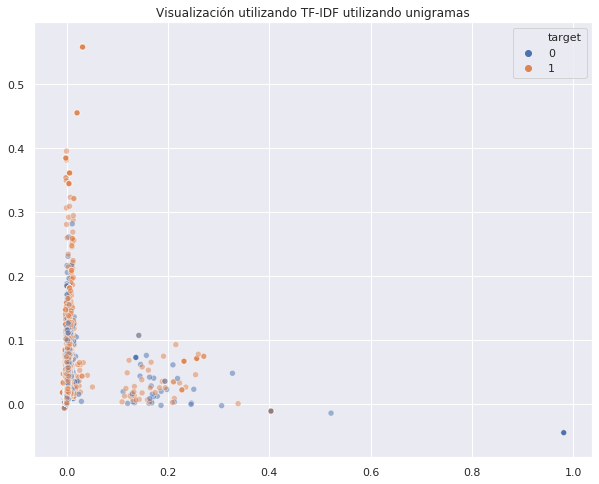

In [23]:
unigram_tfidfv = TfidfVectorizer()
unigrams = unigram_tfidfv.fit_transform(df['text']).toarray()

svd = TruncatedSVD()
reduced_unigrams = svd.fit_transform(unigrams)

plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=reduced_unigrams[:,0], y=reduced_unigrams[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando TF-IDF utilizando unigramas")
plt.show()

# t-SNE

## Unigramas

In [24]:
unigram_cv = CountVectorizer()
unigrams = unigram_cv.fit_transform(df['text'])

svd = TruncatedSVD(n_components=50)
reduced_unigrams = svd.fit_transform(unigrams)

tsne = TSNE(verbose=1, n_iter=500, perplexity=10)
tsne_result_uni = tsne.fit_transform(reduced_unigrams)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7613 samples in 0.016s...
[t-SNE] Computed neighbors for 7613 samples in 6.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7613
[t-SNE] Computed conditional probabilities for sample 2000 / 7613
[t-SNE] Computed conditional probabilities for sample 3000 / 7613
[t-SNE] Computed conditional probabilities for sample 4000 / 7613
[t-SNE] Computed conditional probabilities for sample 5000 / 7613
[t-SNE] Computed conditional probabilities for sample 6000 / 7613
[t-SNE] Computed conditional probabilities for sample 7000 / 7613
[t-SNE] Computed conditional probabilities for sample 7613 / 7613
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.740761
[t-SNE] KL divergence after 500 iterations: 1.304413


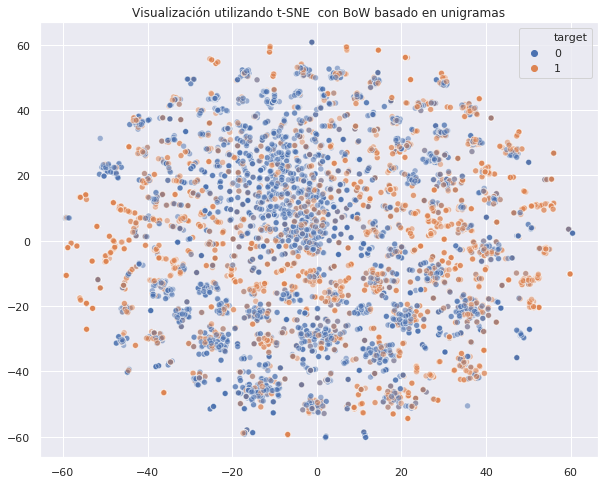

In [25]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=tsne_result_uni[:,0], y=tsne_result_uni[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando t-SNE  con BoW basado en unigramas")
plt.show()

## Bigramas

In [26]:
bigram_cv = CountVectorizer()
bigrams = bigram_cv.fit_transform(df['text'])

svd = TruncatedSVD(n_components=50)
reduced_bigrams = svd.fit_transform(bigrams)

tsne = TSNE(verbose=1, n_iter=500, perplexity=10)
tsne_result_bi = tsne.fit_transform(reduced_bigrams)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7613 samples in 0.012s...
[t-SNE] Computed neighbors for 7613 samples in 6.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7613
[t-SNE] Computed conditional probabilities for sample 2000 / 7613
[t-SNE] Computed conditional probabilities for sample 3000 / 7613
[t-SNE] Computed conditional probabilities for sample 4000 / 7613
[t-SNE] Computed conditional probabilities for sample 5000 / 7613
[t-SNE] Computed conditional probabilities for sample 6000 / 7613
[t-SNE] Computed conditional probabilities for sample 7000 / 7613
[t-SNE] Computed conditional probabilities for sample 7613 / 7613
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.876129
[t-SNE] KL divergence after 500 iterations: 1.306373


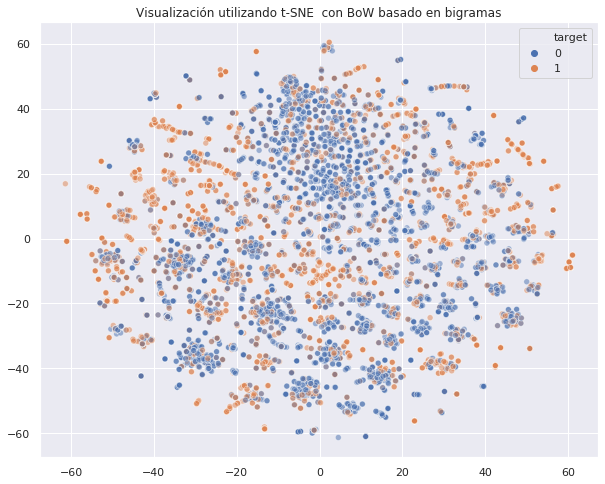

In [27]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=tsne_result_bi[:,0], y=tsne_result_bi[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando t-SNE  con BoW basado en bigramas")
plt.show()

## Trigramas

In [28]:
trigram_cv = CountVectorizer()
trigrams = trigram_cv.fit_transform(df['text'])

svd = TruncatedSVD(n_components=50)
reduced_trigrams = svd.fit_transform(trigrams)

tsne = TSNE(verbose=1, n_iter=500, perplexity=10)
tsne_result_tri = tsne.fit_transform(reduced_trigrams)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7613 samples in 0.018s...
[t-SNE] Computed neighbors for 7613 samples in 5.663s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7613
[t-SNE] Computed conditional probabilities for sample 2000 / 7613
[t-SNE] Computed conditional probabilities for sample 3000 / 7613
[t-SNE] Computed conditional probabilities for sample 4000 / 7613
[t-SNE] Computed conditional probabilities for sample 5000 / 7613
[t-SNE] Computed conditional probabilities for sample 6000 / 7613
[t-SNE] Computed conditional probabilities for sample 7000 / 7613
[t-SNE] Computed conditional probabilities for sample 7613 / 7613
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.147903
[t-SNE] KL divergence after 500 iterations: 1.311107


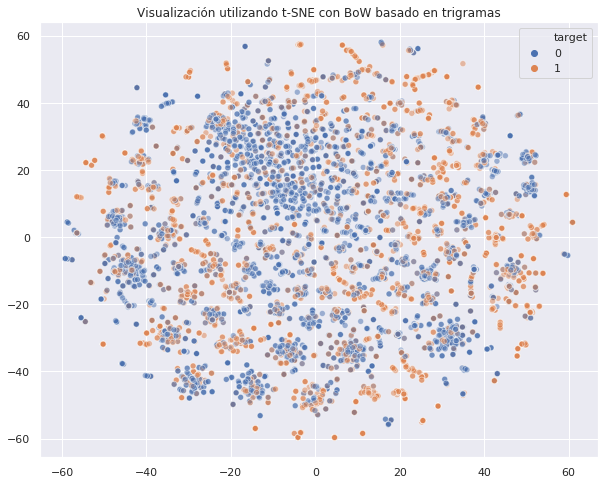

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x=tsne_result_tri[:,0], y=tsne_result_tri[:,1], alpha=0.5, hue='target')
plt.title("Visualización utilizando t-SNE con BoW basado en trigramas")
plt.show()